In [1]:
# Import data science environmemnt.
import math
import warnings

from IPython.display import display
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model 
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import statsmodels.formula.api as smf

# Display preferences
% matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd'
)
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv', skiprows=3, header=1)
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan


In [3]:
# Change long column names.
df.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder"})

,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan
5,Alfred Village,"4,089",5,0.000,nan,0,3,2,46,10,36,0,nan
6,Allegany Village,"1,781",3,0.000,nan,0,0,3,10,0,10,0,0.000
7,Amherst Town,"118,296",107,1.000,nan,7,31,68,"2,118",204,"1,882",32,3.000
8,Amityville Village,"9,519",9,0.000,nan,2,4,3,210,16,188,6,1.000
9,Amsterdam,"18,182",30,0.000,nan,0,12,18,405,99,291,15,0.000


In [4]:
# Eliminate commas from number > 999.
def convert_number(number):
    try:
        converted = float(number.replace(',', ''))
    except:
        converted = number
        
    return converted

In [5]:
# Change NaN values to 0. Convert object types to floats.
df.dropna()
df['Population'] = df['Population'].apply(lambda x: convert_number(x))
df['Population^2'] = df['Population']**2
df['Murder'] = df['Murder and\nnonnegligent\nmanslaughter'].apply(lambda x: convert_number(x))
df['Robbery'] = df['Robbery'].apply(lambda x: convert_number(x))
df['Property_Crime'] = df['Property\ncrime'].apply(lambda x: convert_number(x))

In [6]:
# Eliminate final three rows of text after data.
df = df[:348]

In [7]:
# Create new data frame with only relevant columns.
df_fbi = df[['Population', 'Population^2', 'Murder', 'Robbery', 'Property_Crime']]

In [8]:
# Preview new data frame.
df_fbi.head()

,Population,Population^2,Murder,Robbery,Property_Crime
0,1861.000,3463321.000,0.000,0.000,12.000
1,2577.000,6640929.000,0.000,0.000,24.000
2,2846.000,8099716.000,0.000,0.000,16.000
3,97956.000,9595377936.000,8.000,227.000,4090.000
4,6388.000,40806544.000,0.000,4.000,223.000


In [9]:
names = df_fbi.columns
df_fbi_scaled = pd.DataFrame(preprocessing.scale(df_fbi), columns=names)
df_fbi_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 5 columns):
Population        348 non-null float64
Population^2      348 non-null float64
Murder            348 non-null float64
Robbery           348 non-null float64
Property_Crime    348 non-null float64
dtypes: float64(5)
memory usage: 13.7 KB


In [10]:
# Build our knn model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
Y = df_fbi_scaled['Property_Crime'].values.reshape(-1, 1)
X = df_fbi_scaled['Population'].values.reshape(-1, 1)
knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [11]:
# Set up our prediction line.
T = np.arange(-1, 20, 30)[:, np.newaxis]

In [12]:
# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

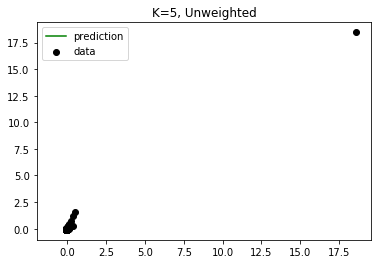

In [13]:
# Scatterplot for visualization.
plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=5, Unweighted')
plt.show()

In [14]:
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.45 (+/- 0.44)


In [15]:
# This seems unremarkable, so let's try a weighted model.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
X = df_fbi_scaled['Population'].values.reshape(-1, 1)
Y = df_fbi_scaled['Property_Crime'].values.reshape(-1, 1)
knn_w.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [16]:
# Set up our prediction line.
T = np.arange(-1, 20, 30)[:, np.newaxis]
# Trailing underscores are a common convention for prediction.
Y_ = knn_w.predict(T)

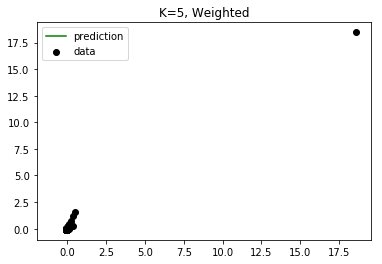

In [17]:
plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=5, Weighted')
plt.show()

In [18]:
score = cross_val_score(knn_w, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.38 (+/- 0.60)


In [19]:
# Run linear regression.
regr = linear_model.LinearRegression()
Y = df_fbi_scaled['Property_Crime'].values.reshape(-1, 1)
X = df_fbi_scaled['Population'].values.reshape(-1, 1)
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R-squared: \n', regr.score(X, Y))

Coefficients: 
 [[0.99626523]]
Intercept: 
 [4.08548535e-17]
R-squared: 
 0.9925444005302549


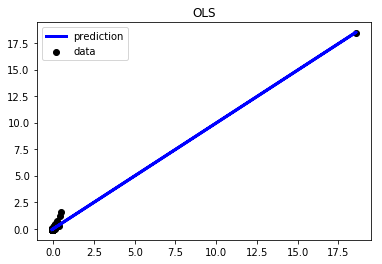

In [21]:
# Plot outputs.
plt.scatter(X, Y, color='k', label='data')
plt.plot(X, regr.predict(X), color='blue', label='prediction', linewidth=3)
plt.legend()
plt.title('OLS')
plt.show()

In [22]:
# Test each model with holdout groups.
from sklearn.model_selection import train_test_split
# Create the necessary training and test groups.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: 0.7850161431886729
Testing on Sample: 0.9925444005302549
